## Data Exploration of IMU Data from TurtleBot3
#### By Jacob Laframboise
This data was collected from RVis in a Gazebo simulation of a TurtleBot3 Waffle Pi robot through ROS. 
The robot was driving on flat surfaces in the 'house' default world for ROS simulation. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp

%matplotlib inline

In [2]:
df= pd.read_csv('subsetBag.csv')
df = df.set_index(['Seq'])
df.head()

,Secs,Nanosecs,OrientX,OrientY,OrientZ,OrientW,AngVelX,AngVelY,AngVelZ,AccelX,AccelY,AccelZ
Seq,,,,,,,,,,,,
0.0,1324.0,514000000.0,0.001044,0.001202,-0.657056,0.753840,0.000015,0.000061,-0.000262,7.743543e-08,4.039488e-08,4.467783e-06
1.0,1324.0,518000000.0,0.001044,0.001202,-0.657056,0.753840,0.000015,0.000061,-0.000262,-1.734290e-08,-3.004739e-08,-1.162637e-10
2.0,1324.0,523000000.0,0.001044,0.001202,-0.657057,0.753839,0.000015,0.000061,-0.000262,-1.734162e-08,-3.005706e-08,-1.165548e-10
3.0,1324.0,528000000.0,0.001044,0.001202,-0.657057,0.753839,0.000015,0.000061,-0.000262,-1.734996e-08,-3.005905e-08,-1.174085e-10
4.0,1324.0,533000000.0,0.001044,0.001202,-0.657058,0.753839,0.000015,0.000061,-0.000262,-1.735201e-08,-3.005913e-08,-1.175825e-10


In [3]:
df.describe()

,Secs,Nanosecs,OrientX,OrientY,OrientZ,OrientW,AngVelX,AngVelY,AngVelZ,AccelX,AccelY,AccelZ
count,24366.000000,2.436600e+04,24366.000000,24366.000000,24366.000000,24366.000000,24366.000000,24366.000000,24366.000000,2.436600e+04,2.436600e+04,2.436600e+04
mean,1384.932939,5.004983e+08,0.000652,0.000571,-0.409955,0.358103,0.000034,0.000068,-0.069091,2.112850e-03,9.612513e-04,6.406907e-07
std,35.175147,2.888570e+08,0.000988,0.000897,0.621573,0.563358,0.003581,0.000923,0.286007,3.543796e-01,2.593589e-01,1.332036e-02
min,1324.000000,1.000000e+06,-0.001587,-0.001590,-0.999999,-0.999999,-0.545459,-0.016366,-1.417108,-3.975749e+01,-1.253969e+00,-1.063808e+00
25%,1354.000000,2.480000e+08,0.001026,-0.000138,-0.665163,-0.087548,-0.000008,0.000015,-0.021398,-1.452808e-06,-2.480055e-05,-8.173077e-06
50%,1385.000000,5.030000e+08,0.001047,0.001197,-0.658515,0.750835,0.000015,0.000061,-0.000260,-1.740837e-08,-2.949089e-08,-1.198066e-10
75%,1415.000000,7.520000e+08,0.001057,0.001200,-0.645476,0.752712,0.000020,0.000071,-0.000256,1.000173e-04,1.608361e-08,4.460768e-08
max,1446.000000,9.990000e+08,0.001593,0.001232,0.999999,0.774419,0.024697,0.087305,1.446494,3.122140e+01,2.237614e+01,6.055230e-01


We have acceleration at each time, and so we can use the fact that velocity is the first integral of acceleration, and position is the second integral of acceleration. Since our acceleration is not determined by a function, we use an implementation of a Riemann sum to find the area under the curve, ie. the velocity and position. This is computed below for all directions. 

In [4]:
# compute the magnitude of the direction vector at each point
df['AccelMag'] = np.sqrt(df['AccelX']**2 + df['AccelY']**2 +df['AccelZ']**2)
# compute the time elapsed since the last frame
df['DeltaT'] = pd.Series([ df.Secs.iloc[i]+df.Nanosecs.iloc[i]/10**9 - df.Secs.iloc[i-1] - df.Nanosecs.iloc[i-1]/10**9 if i>0 else 4000000.0/10**9 for i in range(len(df.index))])

# compute velocity at each time in each direction. 
df['DeltaLinVelX'] = df['DeltaT']*df['AccelX']
df['CurrentVelX'] = pd.Series([df.DeltaLinVelX.iloc[0:i].sum() for i in range(len(df.index))])

df['DeltaLinVelY'] = df['DeltaT']*df['AccelY']
df['CurrentVelY'] = pd.Series([df.DeltaLinVelY.iloc[0:i].sum() for i in range(len(df.index))])

df['DeltaLinVelZ'] = df['DeltaT']*df['AccelZ']
df['CurrentVelZ'] = pd.Series([df.DeltaLinVelZ.iloc[0:i].sum() for i in range(len(df.index))])

In [5]:
# compute position at each time in each direction
df['DeltaPosX'] = df['DeltaT']*df['CurrentVelX']
df['PosX'] = pd.Series([df.DeltaPosX.iloc[0:i].sum() for i in range(len(df.index))])

df['DeltaPosY'] = df['DeltaT']*df['CurrentVelY']
df['PosY'] = pd.Series([df.DeltaPosY.iloc[0:i].sum() for i in range(len(df.index))])

df['DeltaPosZ'] = df['DeltaT']*df['CurrentVelZ']
df['PosZ'] = pd.Series([df.DeltaPosZ.iloc[0:i].sum() for i in range(len(df.index))])


In [6]:
pp.ProfileReport(df)

Number of variables,27
Number of observations,24366
Total Missing (%),0.0%
Total size in memory,5.0 MiB
Average record size in memory,216.0 B
Numeric,18
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,9


In [7]:
df.sum() 
# since the x and y accel is positive sum, 
# the robot must have been moving faster at 
# the end of recoridng than the start. 

Secs            3.374528e+07
Nanosecs        1.219514e+13
OrientX         1.588716e+01
OrientY         1.390694e+01
OrientZ        -9.988965e+03
OrientW         8.725545e+03
AngVelX         8.309985e-01
AngVelY         1.667822e+00
AngVelZ        -1.683466e+03
AccelX          5.148171e+01
AccelY          2.342185e+01
AccelZ          1.561107e-02
AccelMag        1.002100e+03
DeltaT          1.218340e+02
DeltaLinVelX    2.578879e-01
CurrentVelX     1.582875e+03
DeltaLinVelY    1.464053e-01
CurrentVelY     1.877020e+01
DeltaLinVelZ    1.643574e-03
CurrentVelZ     5.303193e+00
DeltaPosX       7.914551e+00
PosX            2.877792e+04
DeltaPosY       9.398165e-02
PosY           -8.030581e+03
DeltaPosZ       2.652648e-02
PosZ            3.394445e+01
dtype: float64

Below is a graph showing acceleration in X,Y,X, and the scalar magnitude of acceleration vector over time.

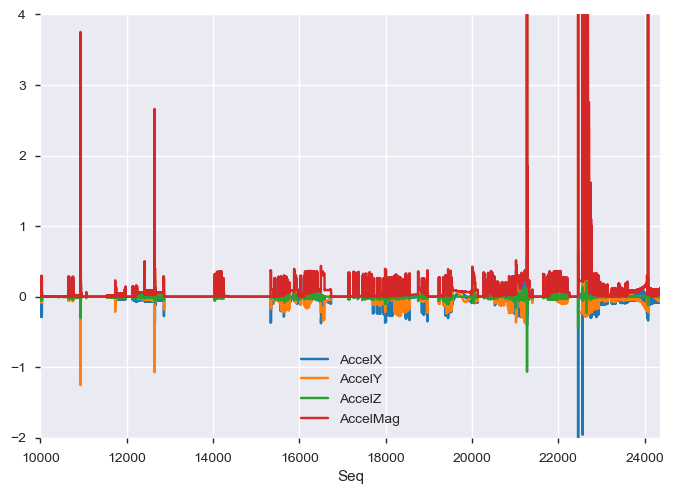

In [8]:
ax3 = df[['AccelX', 'AccelY', 'AccelZ', 'AccelMag']].plot(ylim=(-2, 4), xlim=(10000, None))

Below is a graph showing acceleration in X,Y,Z directions over a zoomed in subset of time. 

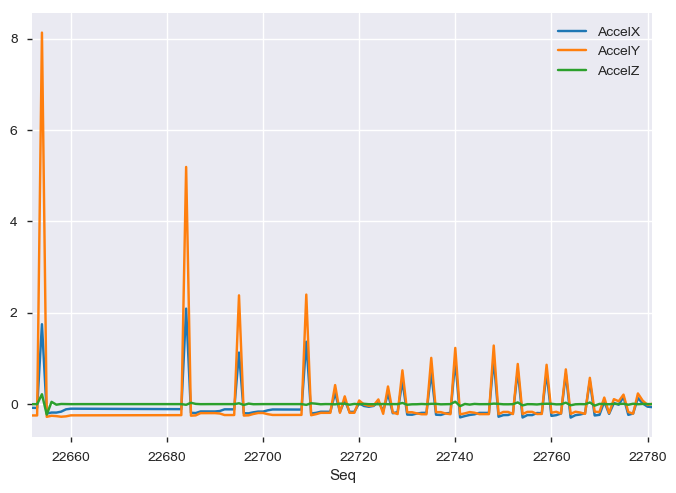

In [9]:
start, end = 22650, 22780
_ = df.iloc[start:end][['AccelX', 'AccelY', 'AccelZ']].plot()

Below is a comparison of the acceleration and angular velocity of the robot in the x direction over time. Differing axis are used as the units and scales are very different. 

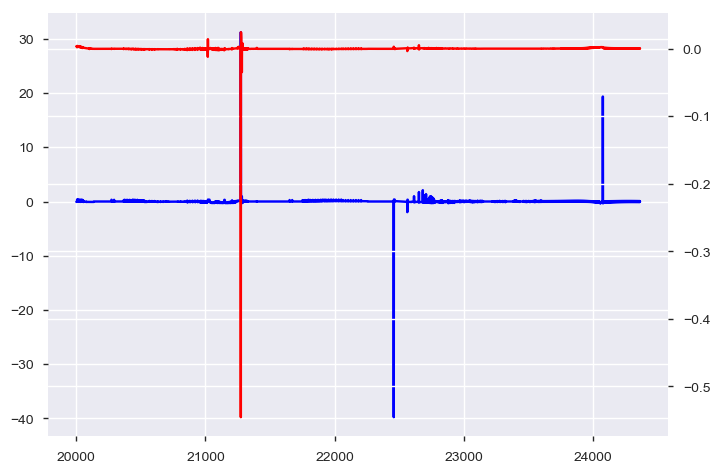

In [10]:
start=20000
dfFocused = df[start:]
fig, ax1 = plt.subplots()
ax1.plot(dfFocused.index, dfFocused.AccelX, color='blue')
# ax1.plot(dfFocused.index, dfFocused.AccelY, color='red')
# ax1.plot(dfFocused.index, dfFocused.AccelZ, color='green')
ax2 = ax1.twinx()
_ = ax2.plot(dfFocused.index, dfFocused.AngVelX, color='red')
# ax2.plot(dfFocused.index, dfFocused.AngVelY, color='red')
# ax2.plot(dfFocused.index, dfFocused.AngVelZ, color='green')

Below is a graph of position, velocity, and acceleration of the robot in the x direction over time. 

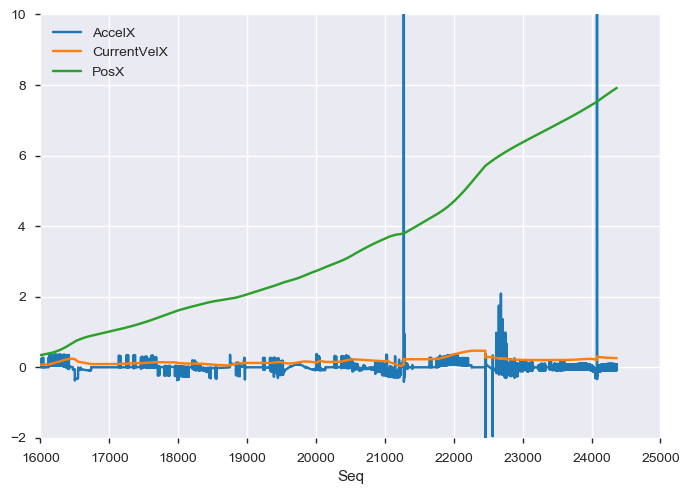

In [11]:
ax4 = df[['AccelX', 'CurrentVelX', 'PosX']].plot(xlim=(16000, 25000), ylim=(-2,10))

Below is a zoomed in version of the graph above, so its easier to see how the acceleration interacts with velocity and position. 

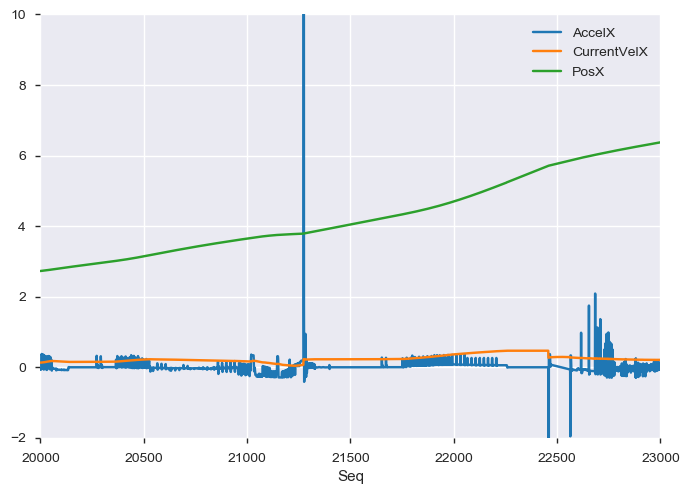

In [12]:
ax5 = df[['AccelX', 'CurrentVelX', 'PosX']].plot(xlim=(20000, 23000), ylim=(-2,10))